## Loads Model, Obtains Predictions, Writes Files, Useful Code Bits

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')
os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [2]:
# Set checkpoint path
checkpoint_path = '/lfs/local/0/jdunnmon/repos/pytorch-classification/checkpoints/cifar100/resnext-8x64d-epochs300-superclass-correct-val-streetcar-bus-repl-gauss-sig1p25'

In [3]:
from analysis.analysis_utils import load_trained_model, fetch_dataloaders
import models.cifar as models

# Loading models 
ind_to_class = {}
class_to_ind = {}

# Optional subsampling/whitening/blurring
subsample_subclass = {}
whiten_subclass = {}
diff_subclass = {}

# Loading trained model
trained_model, args = load_trained_model(checkpoint_path)
dataloaders = fetch_dataloaders(args, subsample_subclass=subsample_subclass, whiten_subclass=whiten_subclass)

# Getting class-to-index maps for CIFAR100
class_to_ind['super'] = dataloaders['test'].dataset.class_to_idx
class_to_ind['sub'] = dataloaders['test'].dataset.fine_class_to_idx

for tp in ['super','sub']:
    ind_to_class[tp] = {v:k for k,v in class_to_ind[tp].items()}

/lfs/raiders2/0/jdunnmon/repos/pytorch-classification/models/cifar/resnext.py:81: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.classifier.weight)
/lfs/raiders2/0/jdunnmon/repos/pytorch-classification/models/cifar/resnext.py:86: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


Using 20 classes...
Files already downloaded and verified
Using coarse labels...
Using coarse labels...


In [4]:
import torch

# Setting cuda
# NOTE: only works for cuda == True for now
use_cuda = True
testloader = dataloaders['test']
if use_cuda:
    trained_model.cuda()
else:
    trained_model.to('cpu')
    trained_model.module.to('cpu')

In [ ]:
import numpy as np
from analysis.analysis_utils import extract_resnext_features

filenames_all = []
coarse_labels_all = []
fine_labels_all = []
fine_preds_all = []
preds_all = []
losses_all = []
softmax_all = []
features_all = []

for batch_idx, (inputs, targets, coarse_labels, fine_labels, filenames) in enumerate(testloader):

    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    else:
        inputs, targets = inputs.cpu(), targets.cpu()
    inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

    # Compute output
    outputs = trained_model(inputs)
    _, preds = outputs.topk(1, 1, True, True)
    soft = torch.nn.Softmax()(outputs)
    feats = extract_resnext_features(trained_model,inputs)
    
    # Record outputs of interest
    coarse_labels_all+=list([int(a) for a in coarse_labels])
    fine_labels_all+=list([int(a) for a in fine_labels])
    preds_all+=list([int(a) for a in preds])
    softmax_all+=list([a.detach().cpu().numpy() for a in soft])
    features_all+=list([a.detach().cpu().numpy() for a in feats])
    filenames_all+=list(filenames)

/lfs/local/0/jdunnmon/repos/anaconda3/envs/pytorch-classification/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/lfs/local/0/jdunnmon/repos/anaconda3/envs/pytorch-classification/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
import pandas as pd

# Creating prediction dataframe for writing
prediction_df = pd.DataFrame({
    'filename':filenames_all,
    'fine_labels':fine_labels_all,
    'coarse_labels':coarse_labels_all,
    'preds':preds_all,
    'fine_labels_string': [ind_to_class['sub'][a] for a in fine_labels_all],
    'coarse_labels_string': [ind_to_class['super'][a] for a in coarse_labels_all],
    'features':features_all,
    'softmax':softmax_all,
})

In [ ]:
# Writing prediction dataframe
prediction_df.to_csv(f"{checkpoint_path}/predictions.tsv",sep='\t')

In [9]:
from sklearn.metrics import accuracy_score
from collections import defaultdict

# Computing superclass accuracy and subclass accuracy
coarse_results = defaultdict(dict)
accuracy_type = 'coarse'
for coarse_class in prediction_df['coarse_labels_string'].unique():
    coarse_accs = {}
    coarse_class_df = prediction_df[prediction_df['coarse_labels_string']==coarse_class]
    coarse_class_acc = accuracy_score(coarse_class_df[f'{accuracy_type}_labels'],coarse_class_df[f'preds'])
    print(f'{coarse_class} superclass {accuracy_type} label accuracy: {coarse_class_acc}')
    coarse_results['superclass'].update({coarse_class:coarse_class_acc})
   # print(f"fine label disribution: {Counter(coarse_class_df['fine_labels_string'])}")
    for ii, fine_class in enumerate(coarse_class_df['fine_labels_string'].unique()):
        fine_class_df = coarse_class_df[coarse_class_df['fine_labels_string']==fine_class]
        fine_class_acc = accuracy_score(fine_class_df[f'{accuracy_type}_labels'],fine_class_df[f'preds'])
        print(f'{fine_class} subclass {accuracy_type} label accuracy: {fine_class_acc}')
        coarse_results[f'subclass_{ii}'].update({coarse_class:fine_class_acc})
    print('\n')

large_natural_outdoor_scenes superclass coarse label accuracy: 0.77
mountain subclass coarse label accuracy: 0.49
forest subclass coarse label accuracy: 0.61
sea subclass coarse label accuracy: 0.9
cloud subclass coarse label accuracy: 0.92
plain subclass coarse label accuracy: 0.93


aquatic_mammals superclass coarse label accuracy: 0.592
seal subclass coarse label accuracy: 0.54
beaver subclass coarse label accuracy: 0.57
whale subclass coarse label accuracy: 0.7
dolphin subclass coarse label accuracy: 0.47
otter subclass coarse label accuracy: 0.68


fruit_and_vegetables superclass coarse label accuracy: 0.85
mushroom subclass coarse label accuracy: 0.65
apple subclass coarse label accuracy: 0.97
orange subclass coarse label accuracy: 0.99
pear subclass coarse label accuracy: 0.88
sweet_pepper subclass coarse label accuracy: 0.76


flowers superclass coarse label accuracy: 0.91
tulip subclass coarse label accuracy: 0.93
rose subclass coarse label accuracy: 0.9
sunflower subclass coa

In [10]:
# Melting dataframe for plotting
plot_df = pd.DataFrame(coarse_results).reset_index()
plot_df = plot_df.rename(columns={"index": "Superclass"})
plot_df = plot_df.melt(id_vars=['Superclass'], var_name='Subset', value_name='Accuracy')

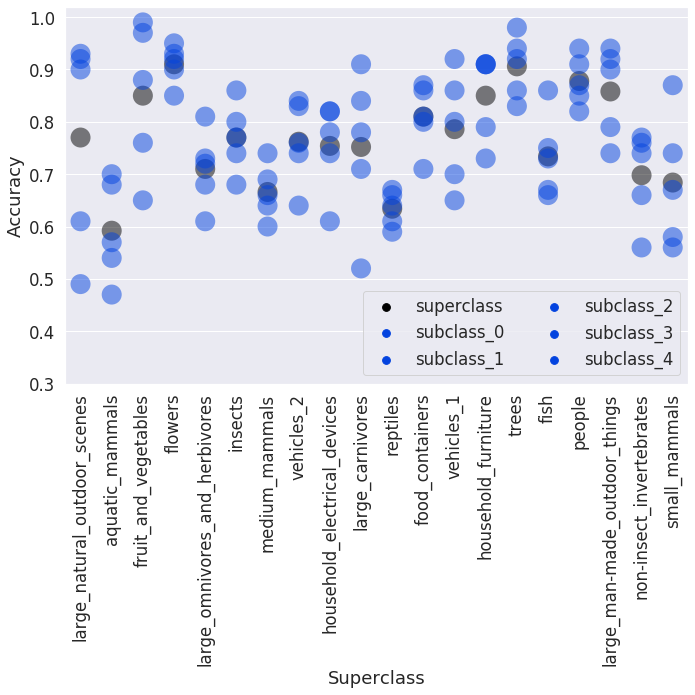

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = [sns.xkcd_rgb["black"]] + 5*[sns.xkcd_rgb["blue"]]
sns.set(font_scale=1.5)
f = plt.figure(figsize=(10,10))
ax = sns.stripplot(x="Superclass", y="Accuracy", hue="Subset", data=plot_df, jitter=False, s=20, palette=palette, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
h,l = ax.get_legend_handles_labels()
ax.legend_.remove()
ax.legend(h,l, ncol=2, loc='lower right')
ax.set_ylim([0.3,1.02])
plt.tight_layout()
plt.savefig('Superclass-Subclass-CIFAR-100-Correct-Val.png',format='png')
plt.show()

## SANDBOX

In [38]:
# Code for getting class-ti-ind map
ind_to_class['super']

{0: 'aquatic_mammals',
 1: 'fish',
 2: 'flowers',
 3: 'food_containers',
 4: 'fruit_and_vegetables',
 5: 'household_electrical_devices',
 6: 'household_furniture',
 7: 'insects',
 8: 'large_carnivores',
 9: 'large_man-made_outdoor_things',
 10: 'large_natural_outdoor_scenes',
 11: 'large_omnivores_and_herbivores',
 12: 'medium_mammals',
 13: 'non-insect_invertebrates',
 14: 'people',
 15: 'reptiles',
 16: 'small_mammals',
 17: 'trees',
 18: 'vehicles_1',
 19: 'vehicles_2'}

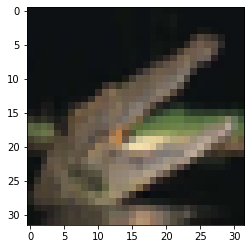

In [60]:
# Code for looking at images
import matplotlib.pyplot as plt
plt.imshow(dataloaders['test'].dataset.data['data'][112])

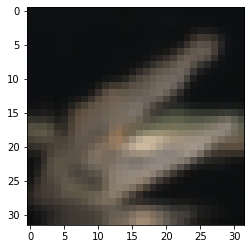

In [61]:
# Code for blurring images
from scipy.ndimage.filters import gaussian_filter
plt.imshow(gaussian_filter(dataloaders['test'].dataset.data['data'][112], sigma=0.75))

In [4]:
import pickle
# Code for opening metadata file
with open('data/cifar-100-python/meta','rb') as fl:
    test_set = pickle.load(fl, encoding='latin1')

In [12]:
import ast
# Code for literal evaluation of string arguments
ast.literal_eval(str({'mountain':0.25, "dolphin":0.25}))['mountain']

0.25

In [13]:
import pickle
with open('utils/cifar100_fine_class_to_idx.pkl', 'wb') as fl:
    pickle.dump(class_to_ind['super'],fl)